In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P28DL'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 26575 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass', 'Class_broad'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4659 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass', 'Class_broad'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

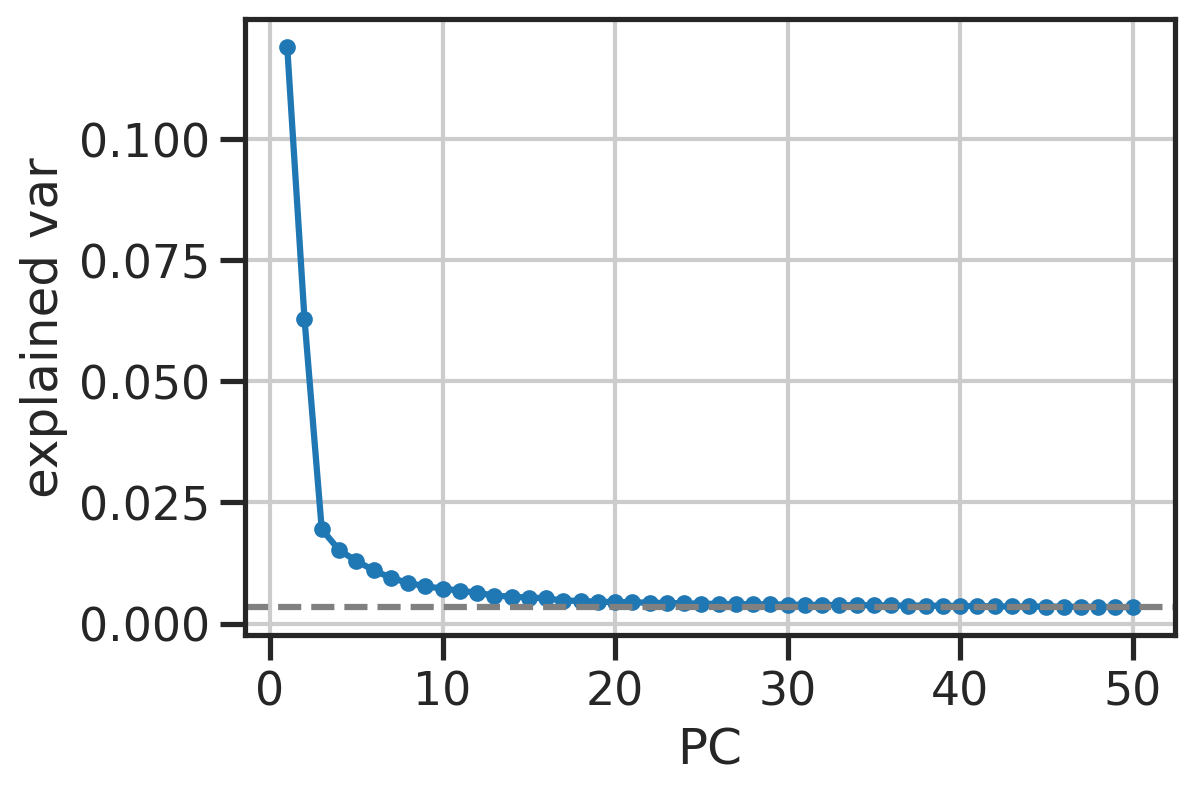

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

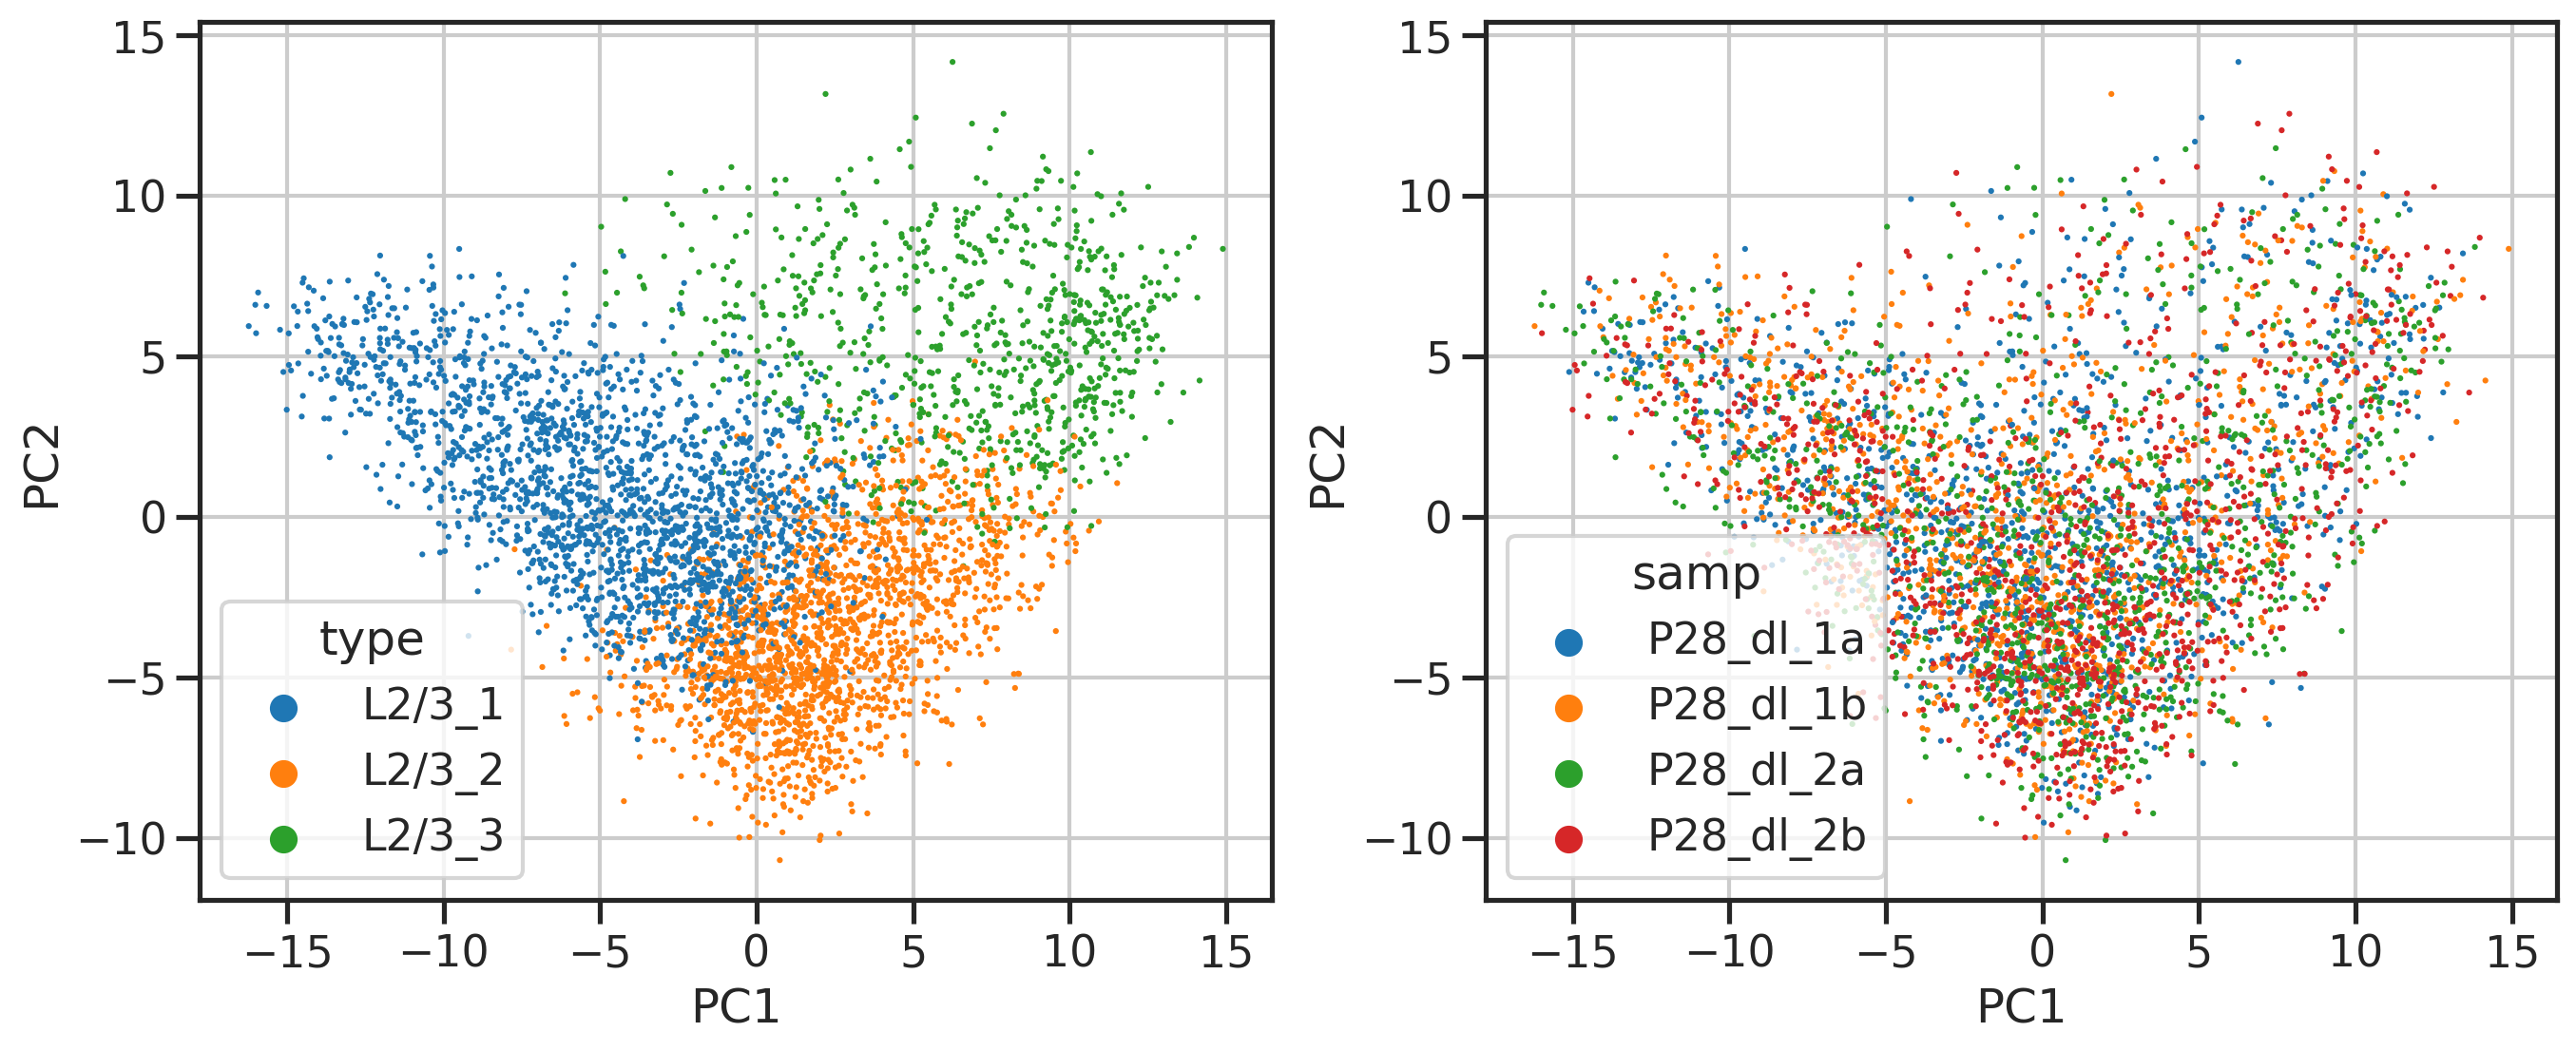

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

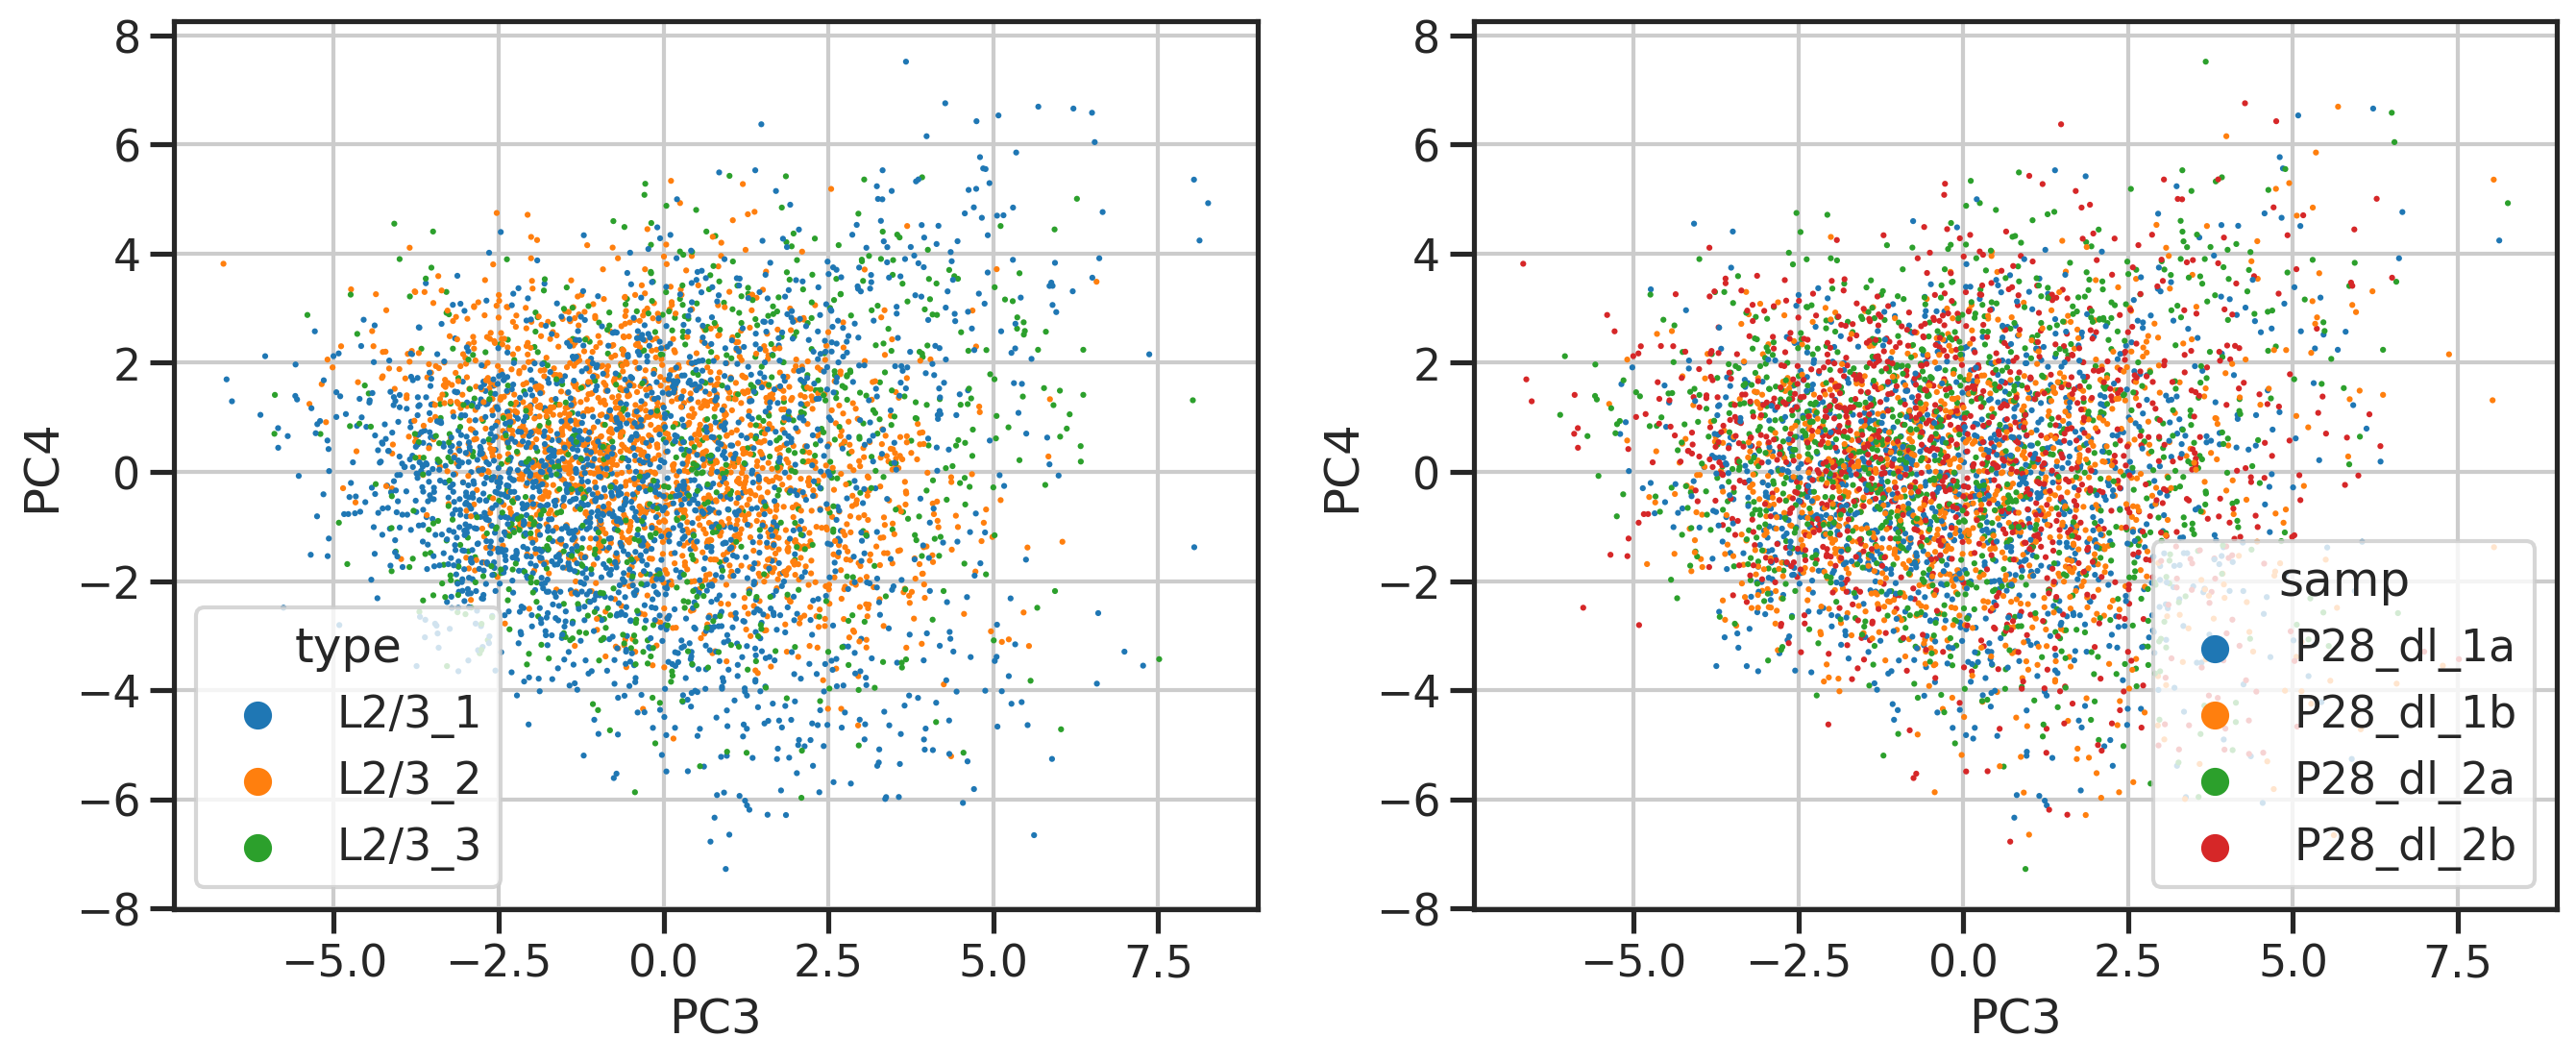

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

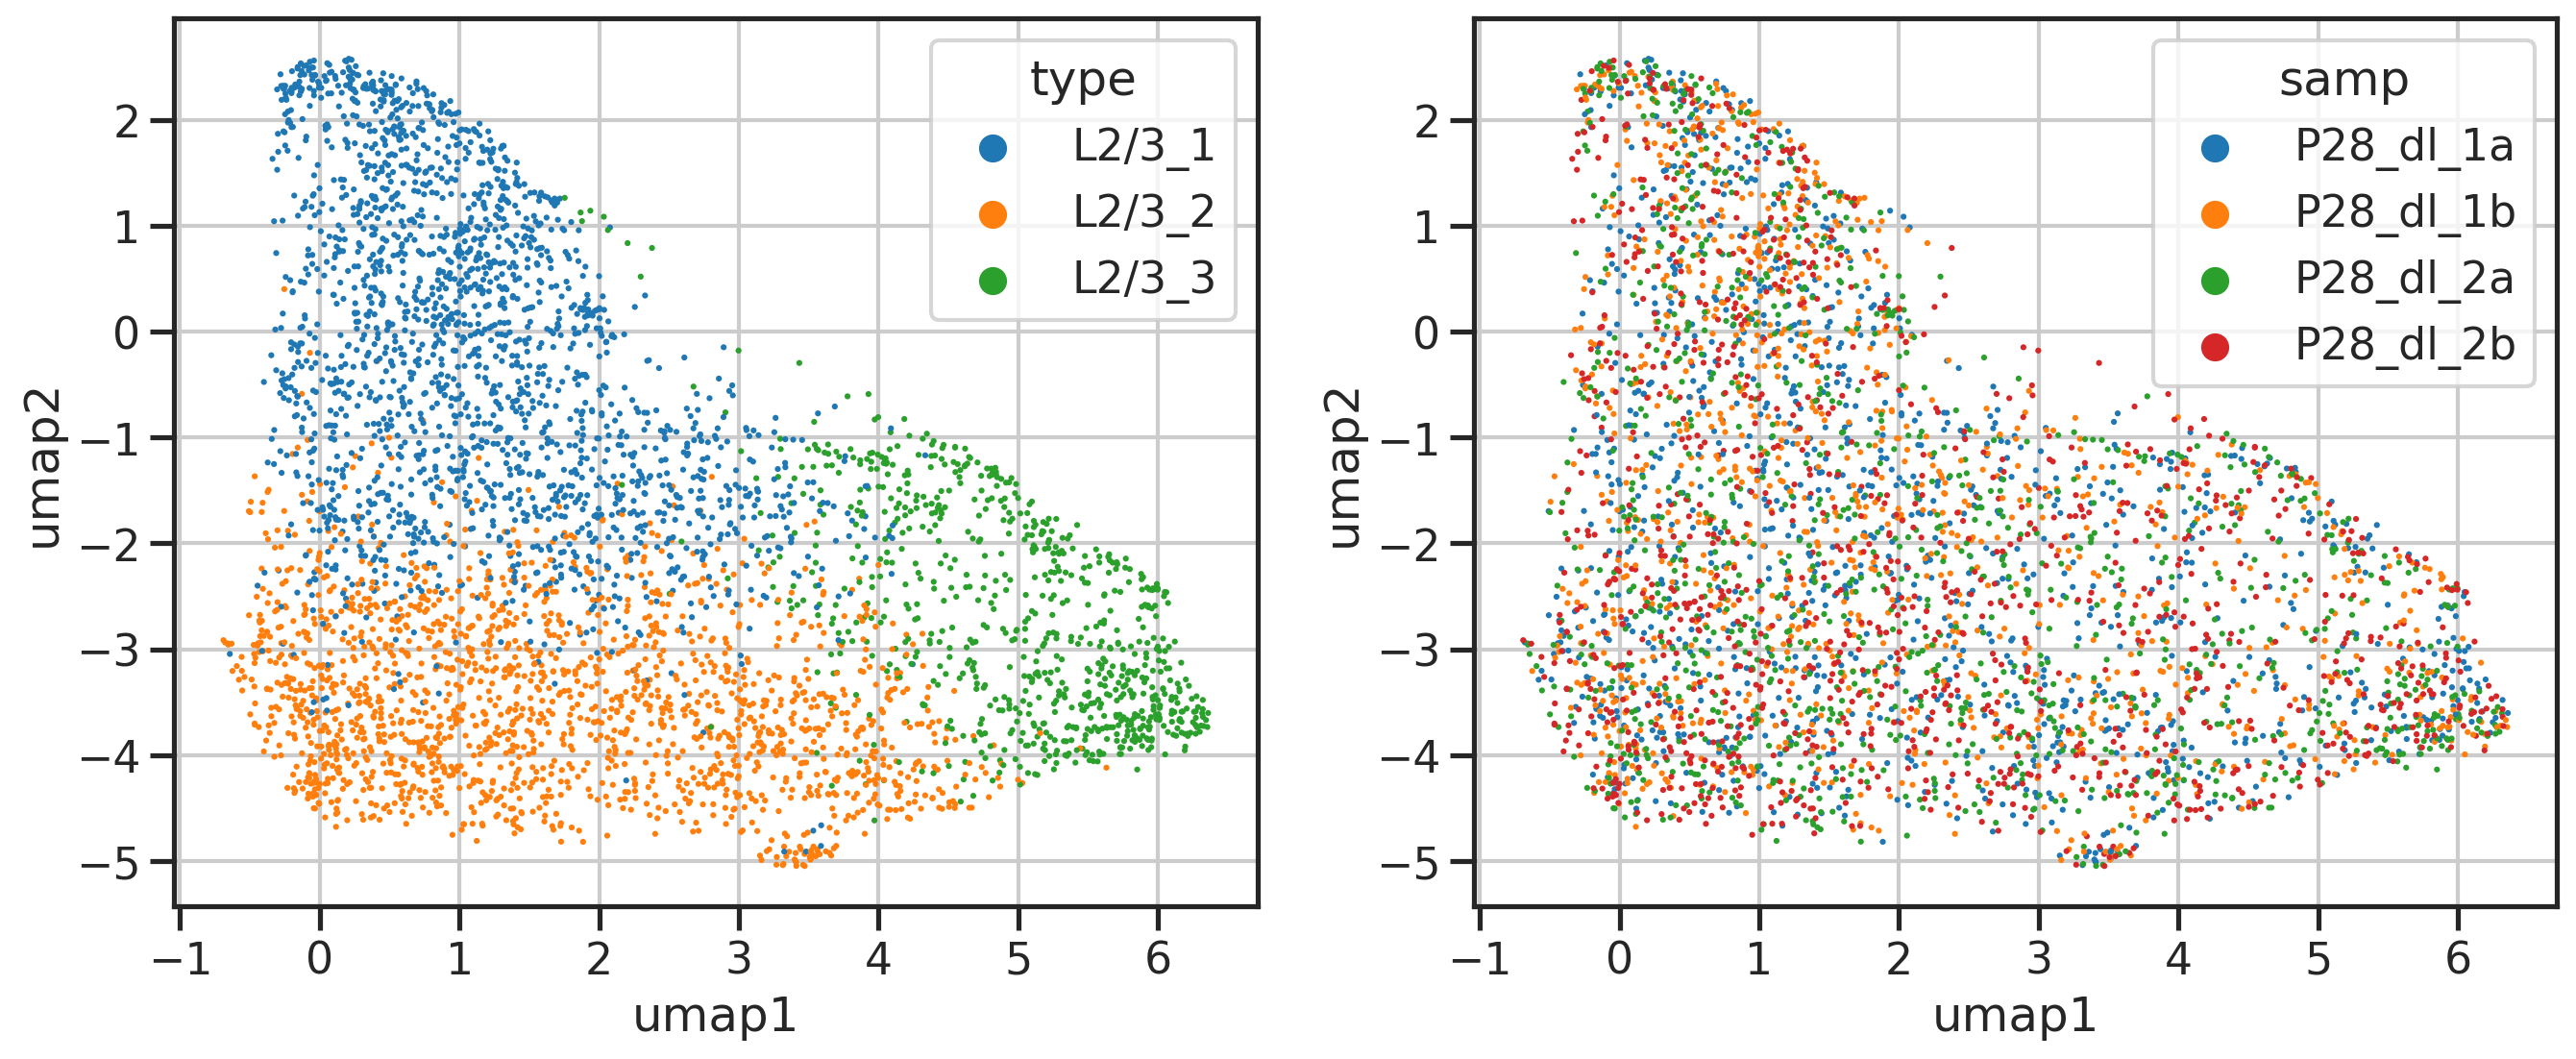

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

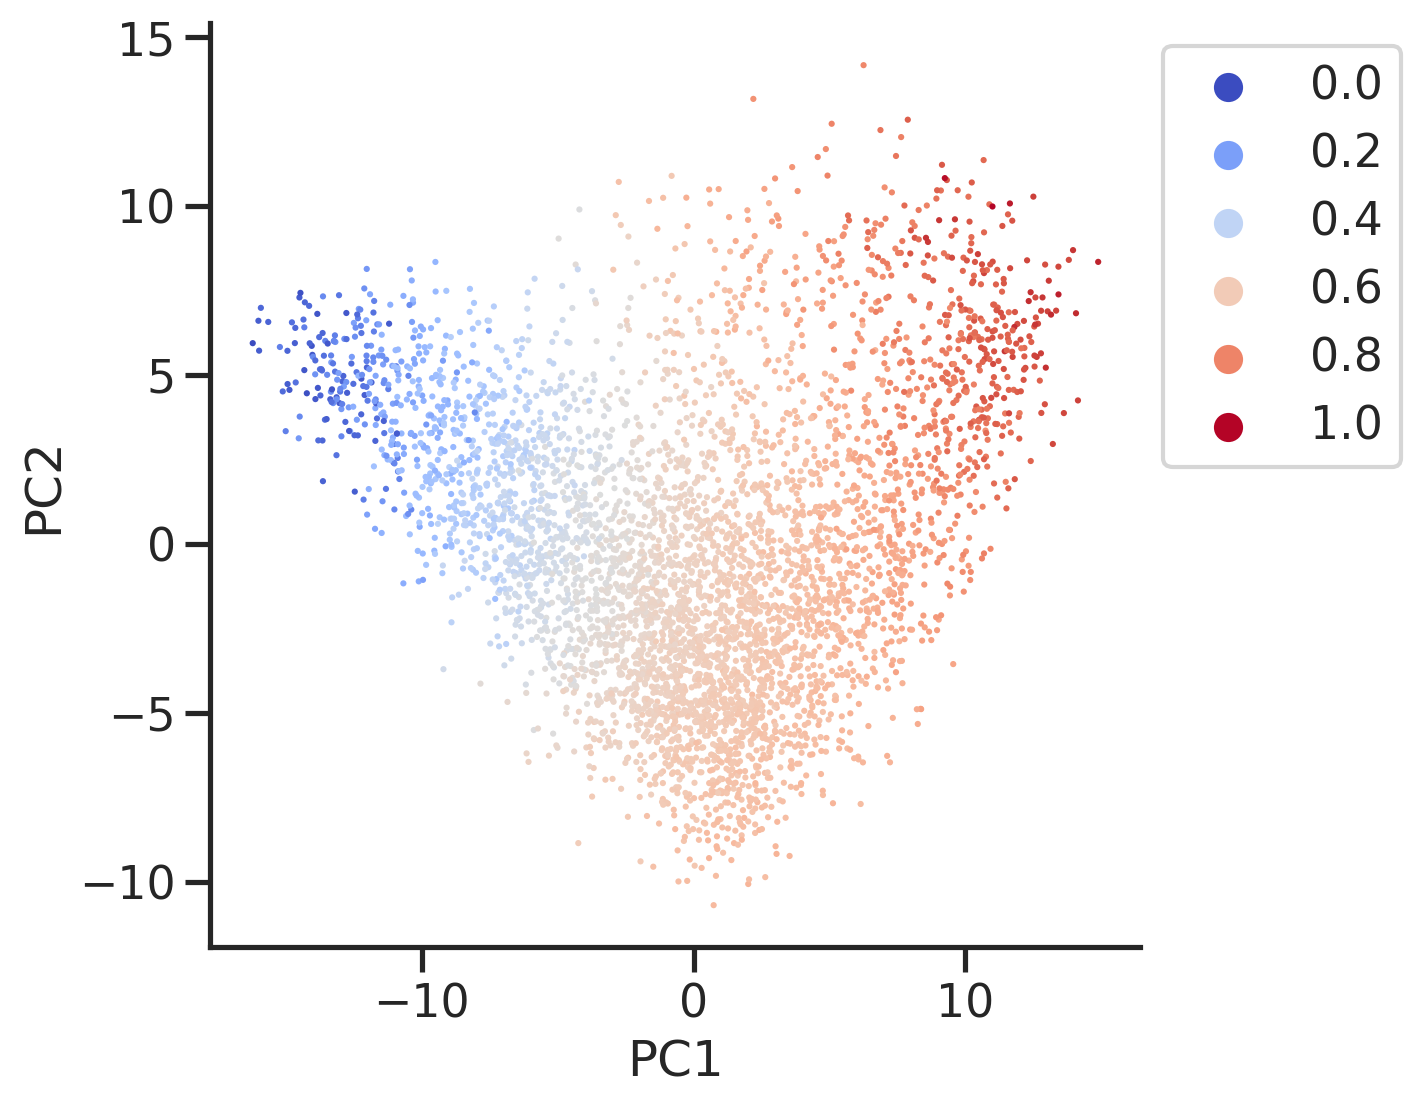

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:06:28 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


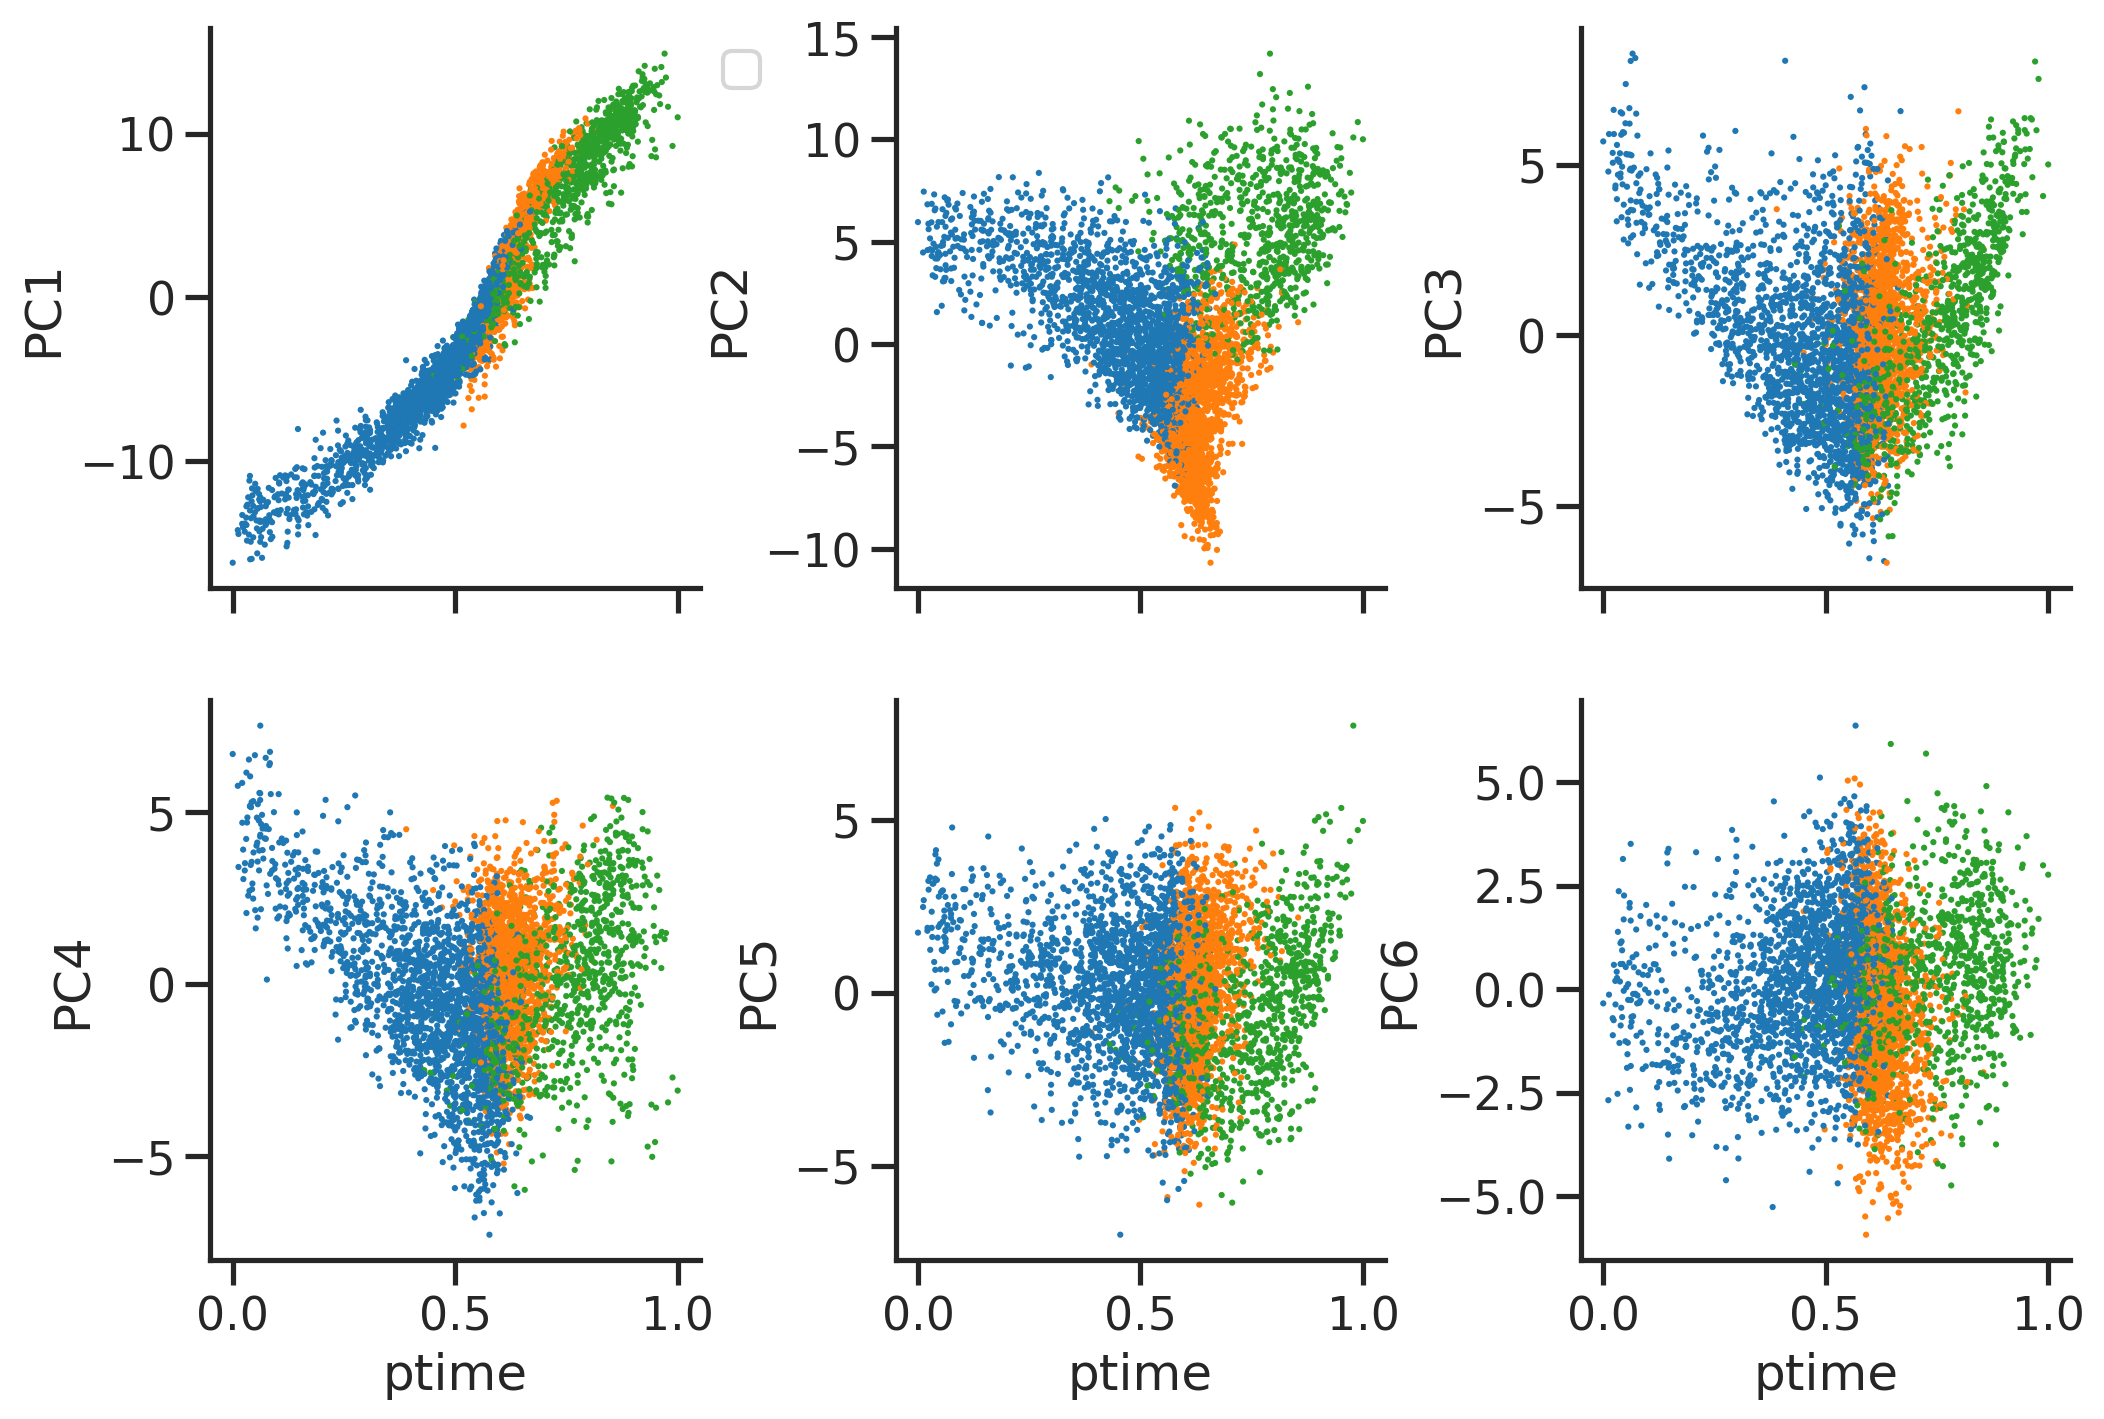

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:06:33 - maxp pruned
03-28 14:06:33 - cmap pruned
03-28 14:06:33 - kern dropped
03-28 14:06:33 - post pruned
03-28 14:06:33 - FFTM dropped
03-28 14:06:33 - GPOS pruned
03-28 14:06:33 - GSUB pruned
03-28 14:06:33 - name pruned
03-28 14:06:33 - glyf pruned
03-28 14:06:33 - Added gid0 to subset
03-28 14:06:33 - Added first four glyphs to subset
03-28 14:06:33 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:06:33 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'L', 'P', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:06:33 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 39, 42, 47, 51, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:06:33 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:06:33 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'L', 'P'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28DL_v4_2023-03-28.pdf


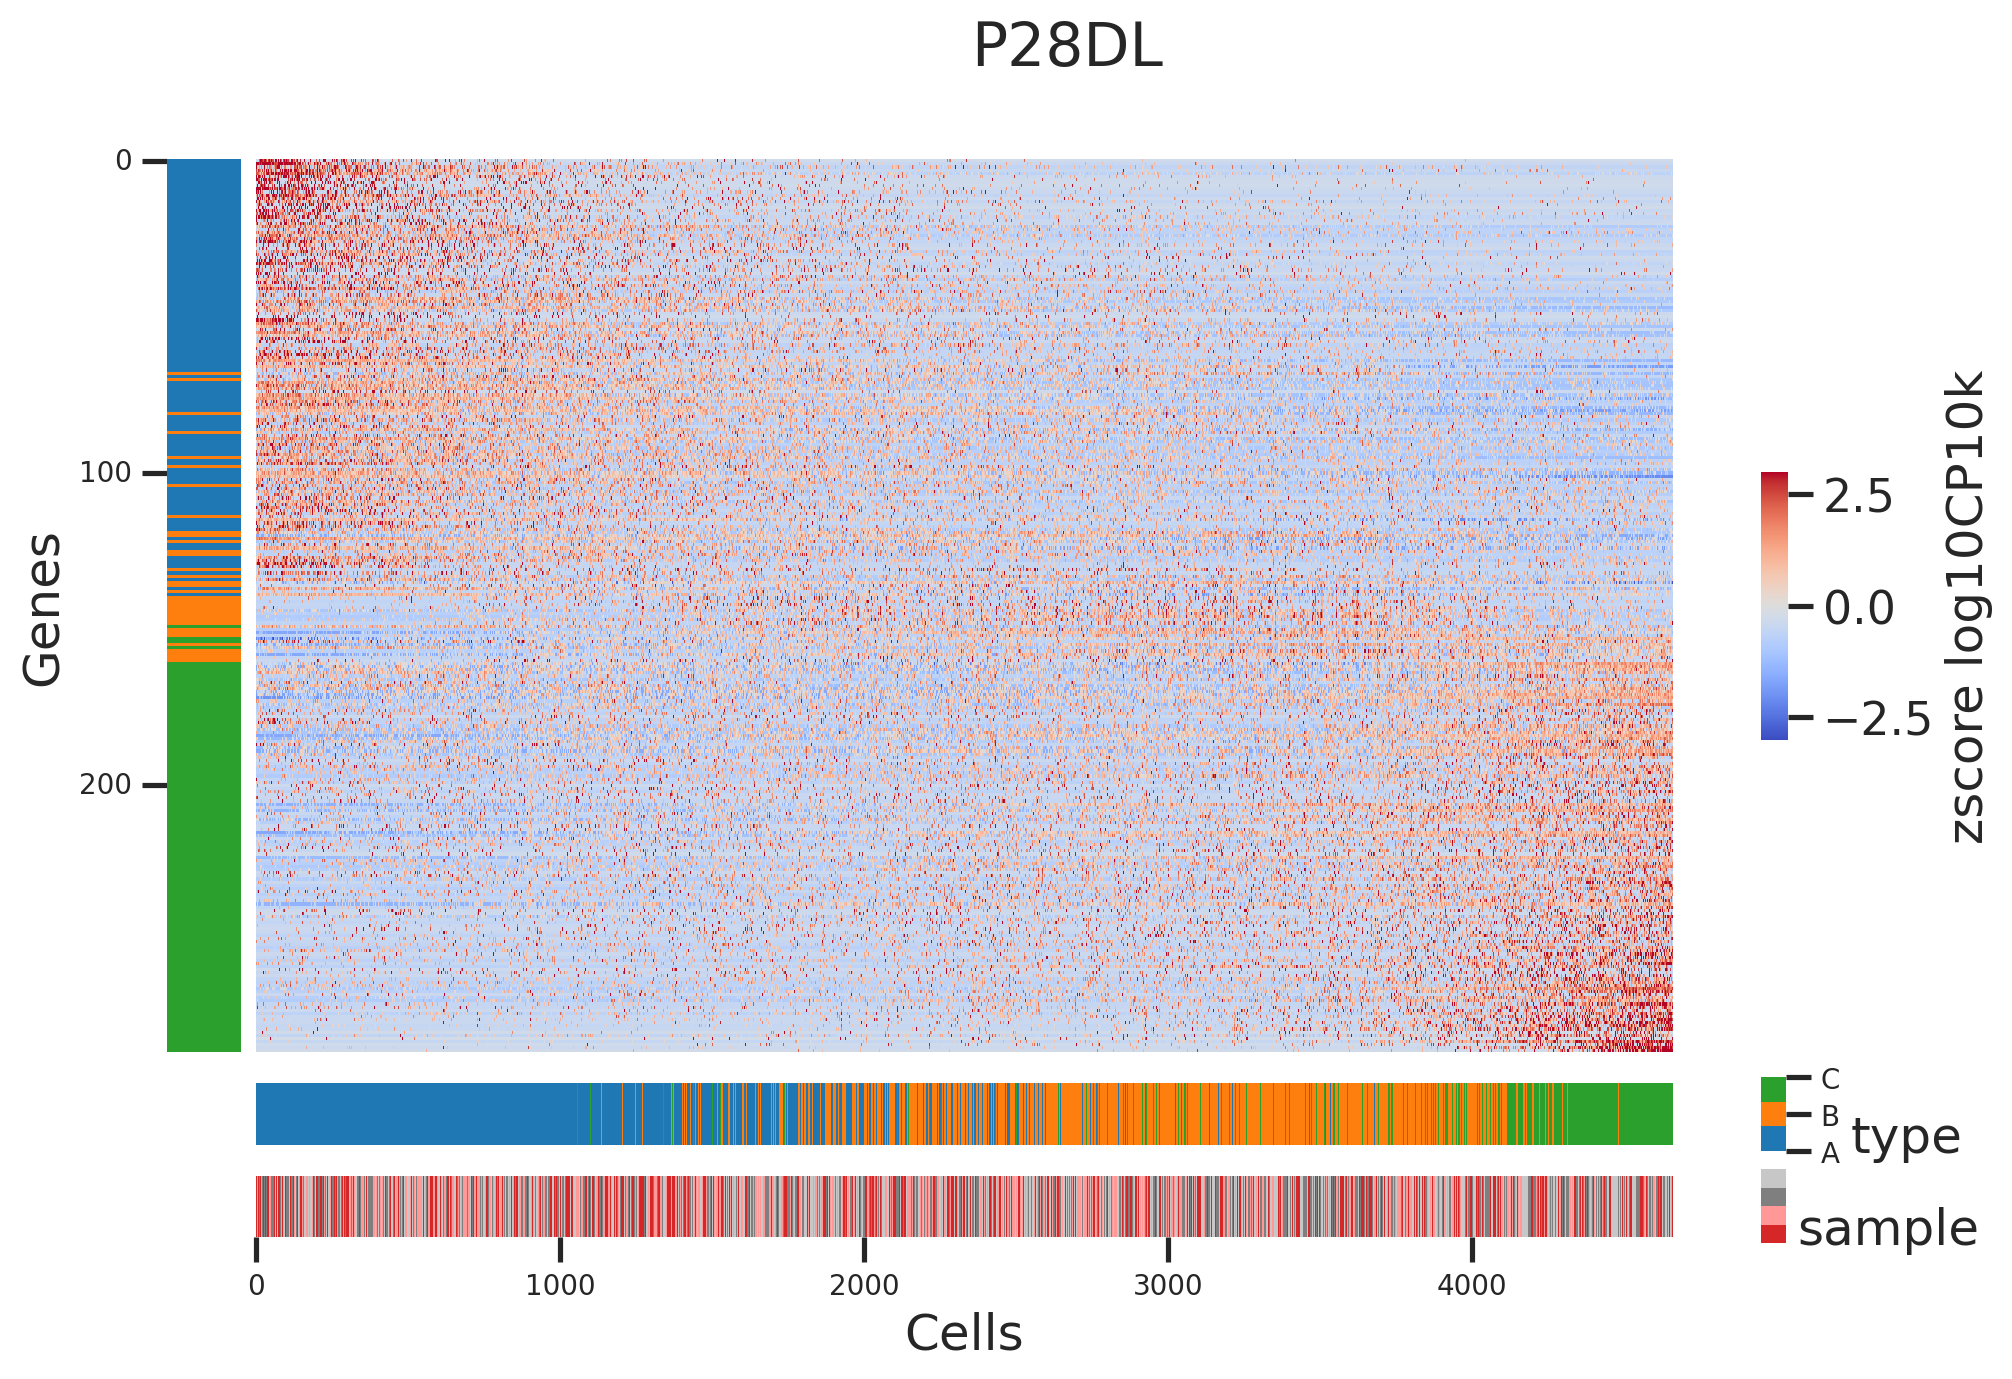

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCACAAACCATC-1-P28_dl_1a   2.894982 -3.778676  2.977634 -2.474946   
AAACGAAAGGGTTAGC-1-P28_dl_1a  10.155253  1.909443  1.489656  1.927927   
AAACGAATCCGACGGT-1-P28_dl_1a  -7.842236 -4.123455  2.725134  2.739116   
AAACGCTTCCAAGAGG-1-P28_dl_1a  -1.297256 -0.340553 -0.244274 -0.693559   
AAAGGGCGTCGAATTC-1-P28_dl_1a  -0.647590 -4.993592  1.039318  1.128778   
...                                 ...       ...       ...       ...   
CGTCCATAGTTGGACG-1-P28_dl_2b  -6.148074  4.404570  1.684055 -0.533262   
GTAGGAGTCGTTGTAG-1-P28_dl_2b  -2.811558  4.593917  1.975137 -2.286833   
TGACTCCCAACTGGTT-1-P28_dl_2b  -6.005109  2.264737  3.237567 -1.101009   
CTCCAACAGTTGTAGA-1-P28_dl_1a   2.260639  1.768460  0.952914 -0.212462   
TTCCACGGTATGGGAC-1-P28_dl_1a  -8.051487  3.902389  5.417246  3.193502   

                                   PC5       PC6       PC7       PC8  \
AAACCCACAAACCATC-1-P28_dl_1a  1.826583 -3.247791 -1.621688 -0.164973   
AAACGAAAGGGTTAGC-1-P28_dl_1a  2.470357  0.029182 -0.495674  1.246783   
AAACGAATCCGACGGT-1-P28_dl_1a  0.030048  0.519497 -2.139221  3.357955   
AAACGCTTCCAAGAGG-1-P28_dl_1a -0.811184 -0.963081  2.684398  0.262638   
AAAGGGCGTCGAATTC-1-P28_dl_1a -0.801704  1.860534  2.121224 -0.074121   
...                                ...       ...       ...       ...   
CGTCCATAGTTGGACG-1-P28_dl_2b  0.623456 -0.441637 -2.503269  0.444975   
GTAGGAGTCGTTGTAG-1-P28_dl_2b -0.470963 -0.747645 -1.206820  0.055603   
TGACTCCCAACTGGTT-1-P28_dl_2b -0.240583  1.203128  1.001235 -1.179718   
CTCCAACAGTTGTAGA-1-P28_dl_1a -0.049050  0.408507  0.027195 -1.600586   
TTCCACGGTATGGGAC-1-P28_dl_1a  1.472980  3.385240 -0.644267  0.540776   

                                   PC9      PC10  ...      PC46      PC47  \
AAACCCACAAACCATC-1-P28_dl_1a  1.016200  1.602152  ... -0.140119  0.093050   
AAACGAAAGGGTTAGC-1-P28_dl_1a -3.038198 -0.015935  ... -0.702907 -1.178115   
AAACGAATCCGACGGT-1-P28_dl_1a -1.706965  3.733286  ...  0.128069 -1.092113   
AAACGCTTCCAAGAGG-1-P28_dl_1a  0.924667 -0.721503  ...  0.455724  1.328363   
AAAGGGCGTCGAATTC-1-P28_dl_1a  0.035632  0.553017  ...  0.551090 -0.347867   
...                                ...       ...  ...       ...       ...   
CGTCCATAGTTGGACG-1-P28_dl_2b -1.745962 -0.559114  ... -0.595871  0.037470   
GTAGGAGTCGTTGTAG-1-P28_dl_2b -1.446263 -0.886144  ...  1.074030 -1.351886   
TGACTCCCAACTGGTT-1-P28_dl_2b -0.005337 -1.248394  ... -0.114840 -0.419677   
CTCCAACAGTTGTAGA-1-P28_dl_1a -1.443760  2.074399  ... -0.322569 -0.079146   
TTCCACGGTATGGGAC-1-P28_dl_1a -3.293386  2.017527  ...  2.357106  0.458263   

                                  PC48      PC49      PC50    type       samp  \
AAACCCACAAACCATC-1-P28_dl_1a  0.310505  0.921468  0.159757  L2/3_2  P28_dl_1a   
AAACGAAAGGGTTAGC-1-P28_dl_1a -0.956546 -0.696951 -0.182192  L2/3_3  P28_dl_1a   
AAACGAATCCGACGGT-1-P28_dl_1a  0.159879  2.273262  0.688834  L2/3_2  P28_dl_1a   
AAACGCTTCCAAGAGG-1-P28_dl_1a  1.244839 -2.764164 -0.267564  L2/3_1  P28_dl_1a   
AAAGGGCGTCGAATTC-1-P28_dl_1a -0.514011 -1.157662 -1.756192  L2/3_2  P28_dl_1a   
...                                ...       ...       ...     ...        ...   
CGTCCATAGTTGGACG-1-P28_dl_2b  1.395846 -0.162468 -1.877088  L2/3_1  P28_dl_2b   
GTAGGAGTCGTTGTAG-1-P28_dl_2b  0.970930 -0.481052  0.432155  L2/3_1  P28_dl_2b   
TGACTCCCAACTGGTT-1-P28_dl_2b  0.034299  0.282818 -0.433738  L2/3_1  P28_dl_2b   
CTCCAACAGTTGTAGA-1-P28_dl_1a  0.786983  0.047807  1.488578  L2/3_2  P28_dl_1a   
TTCCACGGTATGGGAC-1-P28_dl_1a  0.008843  0.782155  1.235296  L2/3_1  P28_dl_1a   

                                 umap1     umap2     ptime  
AAACCCACAAACCATC-1-P28_dl_1a  1.572507 -4.497985  0.640448  
AAACGAAAGGGTTAGC-1-P28_dl_1a  5.136813 -4.187985  0.786426  
AAACGAATCCGACGGT-1-P28_dl_1a -0.507505 -1.695652  0.518819  
AAACGCTTCCAAGAGG-1-P28_dl_1a  1.597468 -1.354916  0.541806  
AAAGGGCGTCGAATTC-1-P28_dl_1a  0.376917 -2.974250  0.580168  
...                           

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)